In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-uhaq7zy4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-uhaq7zy4
  Resolved https://github.com/facebookresearch/detectron2.git to commit ebe8b45437f86395352ab13402ba45b75b4d1ddb
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 59.4 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd drive/MyDrive/DeepLearning/panoptic/

/content/drive/MyDrive/DeepLearning/panoptic


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultTrainer, DefaultPredictor, HookBase
from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo
from google.colab import drive
from detectron2.config import get_cfg
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader, build_detection_test_loader
from detectron2.utils.logger import setup_logger
import optuna
from detectron2.data import build_detection_test_loader
import detectron2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
TRAIN_ANNOTATION = './archive/train_val_test_new/coco_training.json'
VAL_ANNOTATION = './archive/train_val_test_new/coco_val.json'
TEST_ANNOTATION = './archive/train_val_test_new/coco_test.json'
IMAGES_DIR = './archive/images/'
MODEL_DIR_PATH = './output/mask_rcnn_models/'

# **Inicijalizacija i treniranje modela**

In [ ]:
dataset_train = 'dataset_train'
dataset_val = 'dataset_val'
dataset_test = 'dataset_test'

In [ ]:
register_coco_instances(dataset_train, {}, TRAIN_ANNOTATION, IMAGES_DIR)
register_coco_instances(dataset_val, {}, VAL_ANNOTATION, IMAGES_DIR)
register_coco_instances(dataset_test, {}, TEST_ANNOTATION, IMAGES_DIR)

In [ ]:
def objective(trial):
    cfg = get_cfg()
    cfg.MODEL.DEVICE = "cuda"
    cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"))

    # Hyperparameter tuning
    cfg.SOLVER.IMS_PER_BATCH = trial.suggest_categorical("IMS_PER_BATCH", [1, 2, 4])
    cfg.SOLVER.BASE_LR = trial.suggest_loguniform("BASE_LR", 1e-5, 1e-2)
    cfg.SOLVER.MAX_ITER = trial.suggest_int("MAX_ITER", 100, 500)
    cfg.SOLVER.STEPS = (trial.suggest_categorical("STEPS", [(300, 400), (200, 300), (100, 150)]))
    cfg.SOLVER.WARMUP_ITERS = trial.suggest_int("WARMUP_ITERS", 0, 1000)
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = trial.suggest_int("BATCH_SIZE_PER_IMAGE", 8, 64)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = trial.suggest_int("NUM_CLASSES", 1, 20)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = trial.suggest_uniform("SCORE_THRESH_TEST", 0.1, 0.9)

    directory setup
    cfg.DATASETS.TRAIN = ("dataset_train")
    cfg.DATASETS.TEST = ("dataset_val")
    cfg.DATALOADER.NUM_WORKERS = trial.suggest_int("NUM_WORKERS", 2, 8)
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml")
    cfg.OUTPUT_DIR = os.path.join(MODEL_DIR_PATH, f"trial_{trial.number}")
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

    # Evaluation on the validation set
    evaluator = COCOEvaluator("dataset_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
    val_loader = build_detection_test_loader(cfg, "dataset_val")
    metrics = inference_on_dataset(trainer.model, val_loader, evaluator)


    bbox_ap = metrics.get("bbox", {}).get("AP", 0)

    if "losses" not in trial.user_attrs:
        trial.set_user_attr("losses", [])
    trial.user_attrs["losses"].append(-bbox_ap)

    return -bbox_ap


In [ ]:
# Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

best_params = study.best_params
print("Best params:", best_params)

best_trial = study.best_trial
print("Best values:", best_trial.value)
print("Loss values thorough iterations", best_trial.user_attrs["losses"])

In [ ]:
def train_and_log_losses(cfg, model_dir, dataset_train, dataset_val, train_annotation, val_annotation, images_dir):

    register_coco_instances(dataset_train, {}, train_annotation, images_dir)
    register_coco_instances(dataset_val, {}, val_annotation, images_dir)

    class LossLogger(HookBase):
        def __init__(self):
            super().__init__()
            self.losses_per_iter = []

        def after_step(self):
            loss_dict = {
                "total_loss": self.trainer.storage.history("total_loss").latest(),
                "loss_cls_stage0": self.trainer.storage.history("loss_cls_stage0").latest(),
                "loss_box_reg_stage0": self.trainer.storage.history("loss_box_reg_stage0").latest(),
                "loss_cls_stage1": self.trainer.storage.history("loss_cls_stage1").latest(),
                "loss_box_reg_stage1": self.trainer.storage.history("loss_box_reg_stage1").latest(),
                "loss_cls_stage2": self.trainer.storage.history("loss_cls_stage2").latest(),
                "loss_box_reg_stage2": self.trainer.storage.history("loss_box_reg_stage2").latest(),
                "loss_mask": self.trainer.storage.history("loss_mask").latest(),
                "loss_rpn_cls": self.trainer.storage.history("loss_rpn_cls").latest(),
                "loss_rpn_loc": self.trainer.storage.history("loss_rpn_loc").latest(),
            }


            self.losses_per_iter.append(loss_dict)

        def get_losses(self):
            return self.losses_per_iter


    cfg.DATASETS.TRAIN = (dataset_train,)
    cfg.DATASETS.TEST = ()
    cfg.OUTPUT_DIR = os.path.join(model_dir, "final_model")
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


    trainer = DefaultTrainer(cfg)


    loss_logger = LossLogger()
    trainer.register_hooks([loss_logger])


    trainer.resume_or_load(resume=False)
    trainer.train()


    losses = loss_logger.get_losses()
    return losses


def setup_cfg():
    cfg = get_cfg()
    cfg.MODEL.DEVICE = "cuda"
    cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"))


    cfg.SOLVER.IMS_PER_BATCH = 1
    cfg.SOLVER.BASE_LR = 0.0006123760083883984
    cfg.SOLVER.MAX_ITER = 4000
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 31
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml")
    return cfg

# Main deo
setup_logger()
cfg = setup_cfg()
losses = train_and_log_losses(cfg, MODEL_DIR_PATH, dataset_train, dataset_val, TRAIN_ANNOTATION, VAL_ANNOTATION, IMAGES_DIR)


for i, loss_dict in enumerate(losses):
    print(f"Iteracija {i+1}: {loss_dict}")


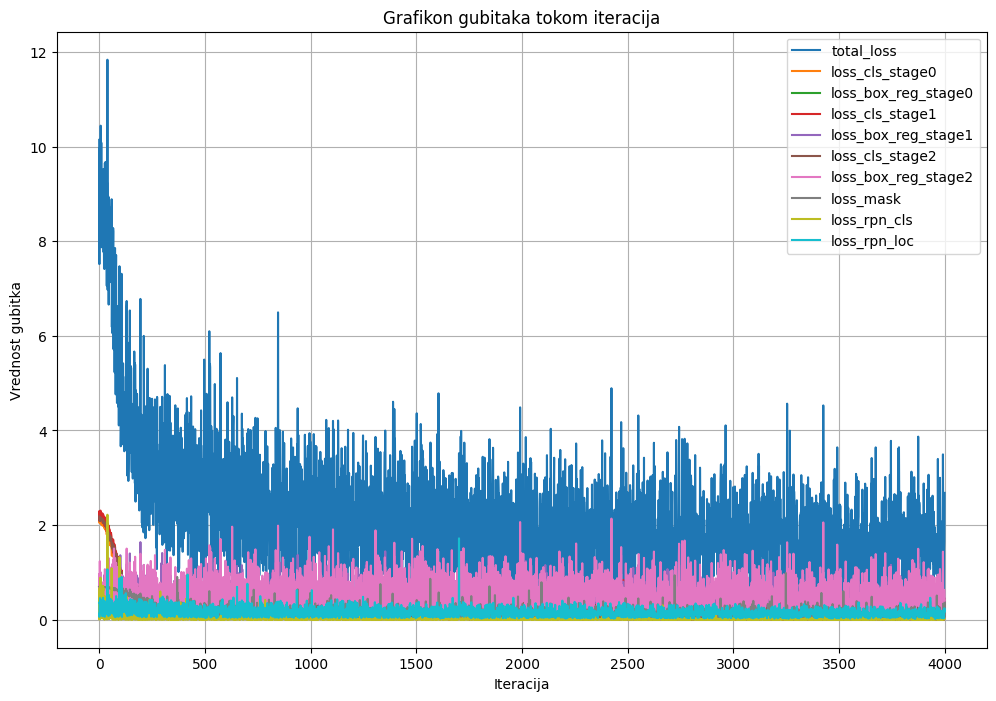

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(losses):
    plt.figure(figsize=(12, 8))

    loss_names = list(losses[0].keys())
    num_losses = len(loss_names)

    for loss_name in loss_names:
        loss_values = [loss[loss_name] for loss in losses]
        plt.plot(loss_values, label=loss_name)

    plt.xlabel('Iteracija')
    plt.ylabel('Vrednost gubitka')
    plt.title('Grafikon gubitaka tokom iteracija')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_losses(losses)


In [ ]:
def print_min_losses(losses):
    loss_names = list(losses[0].keys())

    min_losses = {name: float('inf') for name in loss_names}

    for loss in losses:
        for name in loss_names:
            if loss[name] < min_losses[name]:
                min_losses[name] = loss[name]


    print("Najmanje greške:")
    for name, value in min_losses.items():
        print(f"{name}: {value}")

print_min_losses(losses)


Najmanje greške:
total_loss: 0.2765305010834709
loss_cls_stage0: 0.0016288339393213391
loss_box_reg_stage0: 0.06535831838846207
loss_cls_stage1: 0.0005696373991668224
loss_box_reg_stage1: 0.03754320368170738
loss_cls_stage2: 0.0005992435035295784
loss_box_reg_stage2: 0.0325934961438179
loss_mask: 0.010857593268156052
loss_rpn_cls: 0.0001697194529697299
loss_rpn_loc: 0.015982244163751602


total_loss: Ukupni gubitak za trenutnu iteraciju.
loss_cls_stage0, loss_cls_stage1, loss_cls_stage2: Gubitak klasifikacije na različitim nivoima mreže.
loss_box_reg_stage0, loss_box_reg_stage1, loss_box_reg_stage2: Gubitak za regresiju okvira (bounding box) na različitim nivoima mreže.
loss_mask: Gubitak za maskiranje objekata (instance segmentation).
loss_rpn_cls: Gubitak klasifikacije u mreži za predlaganje regiona (RPN - Region Proposal Network).
loss_rpn_loc: Gubitak za lokalizaciju (odnosno, preciznost predlaganja regiona).


In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

def evaluate_map(cfg, model_dir, dataset_name, annotation_file, images_dir):
    register_coco_instances(dataset_name, {}, annotation_file, images_dir)

    evaluator = COCOEvaluator(dataset_name, cfg, False, output_dir=model_dir)

    val_loader = build_detection_test_loader(cfg, dataset_name)

    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=True)

    results = inference_on_dataset(trainer.model, val_loader, evaluator)

    return results

train_map_results = evaluate_map(cfg, MODEL_DIR_PATH, dataset_train, TRAIN_ANNOTATION, IMAGES_DIR)
test_map_results = evaluate_map(cfg, MODEL_DIR_PATH, "coco_test", TEST_ANNOTATION, IMAGES_DIR)

print("Rezultati na train skupu:", train_map_results)
print("Rezultati na test skupu:", test_map_results)


WARNING [09/24 13:40:17 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/24 13:40:18 d2.data.datasets.coco]: Loaded 564 images in COCO format from ./archive/train_val_test_new/coco_training.json
[09/24 13:40:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/24 13:40:18 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/24 13:40:18 d2.data.common]: Serializing 564 elements to byte tensors and concatenating them all ...
[09/24 13:40:18 d2.data.common]: Serialized dataset takes 6.97 MiB
[09/24 13:40:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[09/24 13:40:20 d2.engine.hooks]: Loading scheduler from state_dict ...
[09/24 13:40:20 d2.evaluation.evaluator]: Start inference on 564 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/24 13:40:22 d2.evaluation.evaluator]: Inference done 11/564. Dataloading: 0.0018 s/iter. Inference: 0.1426 s/iter. Eval: 0.0089 s/iter. Total: 0.1532 s/iter. ETA=0:01:24
[09/24 13:40:28 d2.evaluation.evaluator]: Inference done 41/564. Dataloading: 0.0055 s/iter. Inference: 0.1510 s/iter. Eval: 0.0130 s/iter. Total: 0.1697 s/iter. ETA=0:01:28
[09/24 13:40:33 d2.evaluation.evaluator]: Inference done 62/564. Dataloading: 0.0052 s/iter. Inference: 0.1558 s/iter. Eval: 0.0368 s/iter. Total: 0.1981 s/iter. ETA=0:01:39
[09/24 13:40:38 d2.evaluation.evaluator]: Inference done 87/564. Dataloading: 0.0043 s/iter. Inference: 0.1536 s/iter. Eval: 0.0411 s/iter. Total: 0.1992 s/iter. ETA=0:01:35
[09/24 13:40:43 d2.evaluation.evaluator]: Inference done 106/564. Dataloading: 0.0042 s/iter. Inference: 0.1553 s/iter. Eval: 0.0540 s/iter. Total: 0.2137 s/iter. ETA=0:01:37
[09/24 13:40:48 d2.evaluation.evaluator]: Inference done 127/564. Dataloading: 0.0042 s/iter. Inference: 0.1559 s/iter. Eval: 0.0

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[09/24 13:42:43 d2.engine.hooks]: Loading scheduler from state_dict ...
[09/24 13:42:43 d2.evaluation.evaluator]: Start inference on 200 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[09/24 13:42:46 d2.evaluation.evaluator]: Inference done 11/200. Dataloading: 0.0064 s/iter. Inference: 0.1769 s/iter. Eval: 0.0483 s/iter. Total: 0.2315 s/iter. ETA=0:00:43
[09/24 13:42:51 d2.evaluation.evaluator]: Inference done 35/200. Dataloading: 0.0053 s/iter. Inference: 0.1692 s/iter. Eval: 0.0402 s/iter. Total: 0.2149 s/iter. ETA=0:00:35
[09/24 13:42:57 d2.evaluation.evaluator]: Inference done 65/200. Dataloading: 0.0038 s/iter. Inference: 0.1585 s/iter. Eval: 0.0304 s/iter. Total: 0.1928 s/iter. ETA=0:00:26
[09/24 13:43:02 d2.evaluation.evaluator]: Inference done 92/200. Dataloading: 0.0038 s/iter. Inference: 0.1575 s/iter. Eval: 0.0305 s/iter. Total: 0.1920 s/iter. ETA=0:00:20
[09/24 13:43:07 d2.evaluation.evaluator]: Inference done 110/200. Dataloading: 0.0046 s/iter. Inference: 0.1613 s/iter. Eval: 0.0409 s/iter. Total: 0.2071 s/iter. ETA=0:00:18
[09/24 13:43:12 d2.evaluation.evaluator]: Inference done 130/200. Dataloading: 0.0042 s/iter. Inference: 0.1614 s/iter. Eval: 0.0

In [ ]:
train_map_results['bbox']

{'AP': 85.31203038604428,
 'AP50': 96.52848162242866,
 'AP75': 92.33406657555219,
 'APs': 60.35414395652187,
 'APm': 85.846452082211,
 'APl': 87.32781967743509,
 'AP-Player': 85.69307771154688,
 'AP-Ball': 71.05606268417873,
 'AP-Goal Line': 79.51796895137296,
 'AP-Field': 100.0,
 'AP-Background': 86.35012990494947,
 'AP-Referee': 85.07460884530119,
 'AP-Football Pitch Line': 89.49236460496081}

In [ ]:
train_map_results['segm']

{'AP': 54.86507609937272,
 'AP50': 67.29107215090653,
 'AP75': 61.973720936763534,
 'APs': 19.758073919285792,
 'APm': 41.55075629038884,
 'APl': 70.65391167713734,
 'AP-Player': 69.38591176317027,
 'AP-Ball': 69.25767363534594,
 'AP-Goal Line': 0.0,
 'AP-Field': 99.6837248127623,
 'AP-Background': 80.61366860349122,
 'AP-Referee': 65.11455388083931,
 'AP-Football Pitch Line': 0.0}

# **Ucitavanje istreniranog modela i izvresna predikcija**

[09/24 13:45:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/mask_rcnn_models/final_model/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

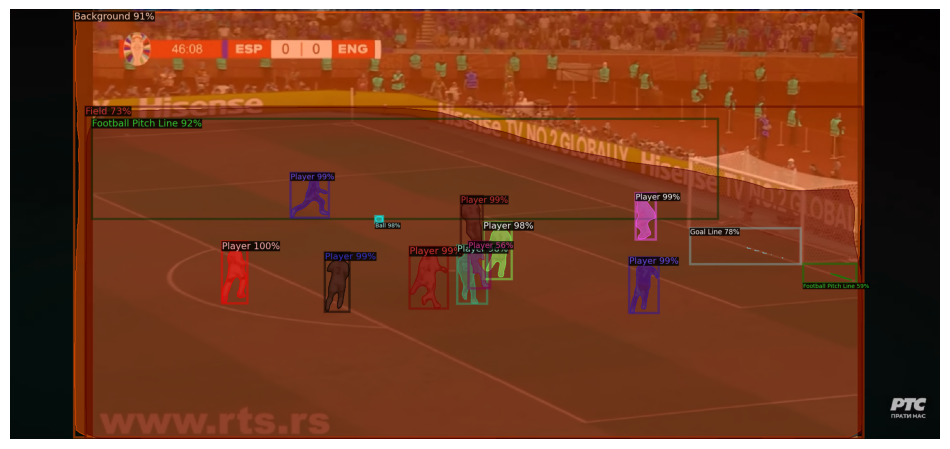

In [ ]:
# Model sto prediktuje samo jednu sliku
import os
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Putanja do treniranog modela
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Prag za predikcije
predictor = DefaultPredictor(cfg)


test_image_path = './archive/random_video_testing/New video.mp4_00123.jpg'
#test_image_path = './archive/images/Football batch 3.mp4_00060.jpg'
im = cv2.imread(test_image_path)


outputs = predictor(im)


v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))


plt.figure(figsize=(12, 12))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()
